# Generating route files to use in SUMO from PSRC TAZ-adjusted data
- https://sumo.dlr.de/docs/od2trips.html

- https://sumo.dlr.de/docs/Demand/Importing_O/D_Matrices.html#splitting_large_matrices

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import xml.dom.minidom as minidom
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

## Configuration of our output

In [57]:
start_time = 5*60 # >=0
end_time = 10*60  # <=1440
demand_scale_factor = 1
time_interval = 15  # minute

input_file = 'psrc_vehicle_trips_converted_taz_calibrated_v2.csv'

# make sure TAZ file is the latest used in the simulation
taz_add_file = 'correct_Alaskan_modified_new_Taz_with_pseudo.add.xml'
# taz_add_file = 'forMFD_Taz_with_pseudo.add.xml'
# taz_add_file = os.path.join(os.path.dirname(os.getcwd()), 'Simulation', 'clean corrected inputs', taz_add_file)


root_folder = 'demand_outputs'
od_folder = f'output_path_{start_time}_{end_time}'
output_name = f'{input_file[:-4]}.rou.xml'
    
od_directory = os.path.join(root_folder, od_folder)
output1_directory = os.path.join(root_folder, 'alaskanway_od2trips_'+output_name)
output2_directory = os.path.join(root_folder, 'exact_'+output_name)
output3_directory = os.path.join(root_folder, 'TAZ_'+output_name)

## read TAZ-adjusted trip file

In [4]:
data = pd.read_csv(input_file)
print(f'len(data): {len(data)}')
data = data.drop_duplicates()  # it drops around 1200 trips
print(f'len(data) after removing duplicates: {len(data)}')
data.loc[data.deptm >= 1440, 'deptm'] = data.deptm - 1440

data = data[(end_time > data.deptm) & (data.deptm >= start_time)]
print(f'len(data) after between {start_time} and {end_time}: {len(data)}')


data = data.sort_values(by=['otaz', 'dtaz', 'deptm', 'travtime'])
data.reset_index(drop=True, inplace=True)
data

C:\Users\Soheil99\AppData\Local\Temp\ipykernel_7820\3633499028.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_file)


len(data): 721697
len(data) after removing duplicates: 720363
len(data) after between 300 and 600: 209284


,otaz,dtaz,deptm,travtime,original_o,original_d,original_deptm
0,426,426,329,6,426,426,329
1,426,426,368,4,426,426,368
2,426,426,453,1,426,426,453
3,426,426,454,9,426,426,454
4,426,426,479,4,426,426,479
...,...,...,...,...,...,...,...
209279,7005,7003,589,18,642,402,582 7.595237342667255
209280,7005,7003,593,18,642,402,582 11.200215393557032
209281,7005,7003,597,16,599,402,580 17.084070221312587
209282,7005,7003,597,17,638,398,590


In [5]:
data[data.otaz==400]

,otaz,dtaz,deptm,travtime,original_o,original_d,original_deptm


## aggregate trips into time-segmented ODs

In [6]:
quotients = data.deptm//time_interval
starts = quotients*time_interval
intervals = starts.astype(str)+"_"+(starts+time_interval).astype(str)
data['interval']= intervals
data.head()

,otaz,dtaz,deptm,travtime,original_o,original_d,original_deptm,interval
0,426,426,329,6,426,426,329,315_330
1,426,426,368,4,426,426,368,360_375
2,426,426,453,1,426,426,453,450_465
3,426,426,454,9,426,426,454,450_465
4,426,426,479,4,426,426,479,465_480


# method1:
## generating rou.xml files for each time segment based on od2trips and origin and destination link

##### Put a route file in a folder for each 15 minutes or each minute (15 minutes makes more sense)

In [7]:
def extract_od(df):
    od_simple = {'O':[], 'D':[], 'demand':[]}
    
    tazs = np.sort(np.unique(df.otaz.values))
    for o in tazs:
        o_df = df[df['otaz']== o]       
        destinations = np.unique(o_df.dtaz.values)
        for d in destinations:
            od_df = o_df[o_df['dtaz'] == d]
            times = od_df.deptm.values             
            od_simple['O'].append(o)
            od_simple['D'].append(d)
            od_simple['demand'].append(len(times))

    od = pd.DataFrame(od_simple)
    return od

In [8]:
def reformat_time(time:str):
    h = time//60
    m = time%60
    string = f'{h}.{m:02d}'
    return string

In [9]:
def generate_od2trip_od_input(df, path, interval):
    OD_data = extract_od(df)
    interval = interval.split('_')
    start_time = reformat_time(int(interval[0]))
    end_time = reformat_time(int(interval[1]))
    
    row, colume = np.shape(OD_data)
    with open(path,"w") as OD:
        OD.write("$OR;\n")
        OD.write("*From time, TO time\n")
        OD.write(f'{start_time} {end_time}\n')
        OD.write("*Factor\n")
        OD.write(f"{demand_scale_factor}\n")
        OD.write(f'*Total demand: {sum(OD_data.demand)}\n')
        OD.write("*Origin\tDestination\tDemand:\n")
        for i in range(len(OD_data)):
            OD.write(f"{OD_data.iloc[i,0]} {OD_data.iloc[i,1]} {OD_data.iloc[i,2]}\n")
        OD.close()
    return OD_data

In [10]:
try: 
    os.mkdir(od_directory) 
except OSError as error: 
    print(error)
# os.chdir(od_directory)

In [11]:
intervals = sorted(set(intervals), key=lambda a:int(a.split('_')[0]))
demands = list()

od_list = ''  # it should look like: 'file1.txt, file2.txt, file3.txt' with no brackets
for interval in intervals:
    df = data[data.interval == interval]

    od_path = os.path.join(od_directory, f'od_{interval}.txt')    
    print(f'Generate the od_{interval}.txt file')
    od_df = generate_od2trip_od_input(df, od_path, interval)
    demands.append(sum(od_df.demand))
    od_list += (od_path+',')
    
od_list = od_list[:-1]

Generate the od_300_315.txt file
Generate the od_315_330.txt file
Generate the od_330_345.txt file
Generate the od_345_360.txt file
Generate the od_360_375.txt file
Generate the od_375_390.txt file
Generate the od_390_405.txt file
Generate the od_405_420.txt file
Generate the od_420_435.txt file
Generate the od_435_450.txt file
Generate the od_450_465.txt file
Generate the od_465_480.txt file
Generate the od_480_495.txt file
Generate the od_495_510.txt file
Generate the od_510_525.txt file
Generate the od_525_540.txt file
Generate the od_540_555.txt file
Generate the od_555_570.txt file
Generate the od_570_585.txt file
Generate the od_585_600.txt file


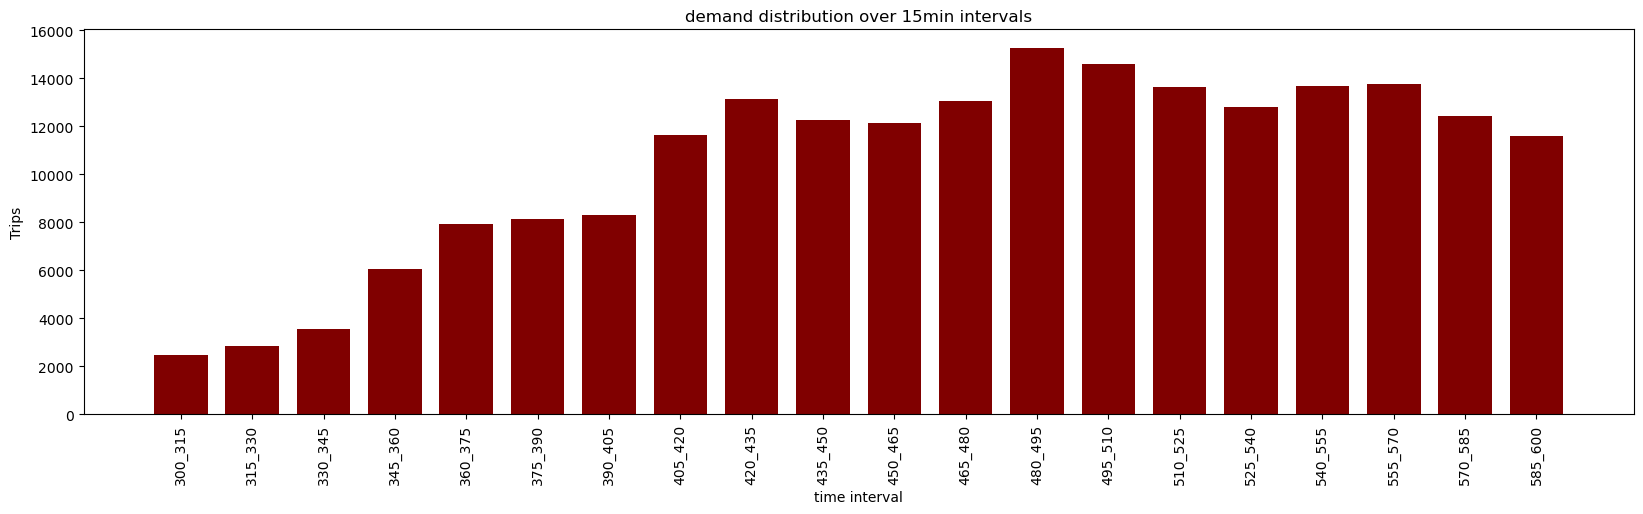

In [12]:
### demand histogram
fig = plt.figure(figsize = (20, 5))

plt.bar(intervals, demands, color ='maroon', width = 0.75)
# plt.bar(intervals, [demand/len(data) for demand in demands], color ='maroon', width = 0.75)
plt.xticks(rotation='vertical')
plt.xlabel("time interval")
plt.ylabel("Trips")
plt.title(f"demand distribution over {time_interval}min intervals")
plt.show()

In [58]:

query = f'od2trips -n {taz_add_file} -d {od_list} -o {output1_directory} --vtype passenger --different-source-sink true --departlane free --departspeed max'
os.system(query)
    

0

#### Add vtype manually to the output later

# Method 2
## generating rou.xml files manually based on origin and destination TAZ

In [53]:
data3 = data.sort_values(by=['deptm','otaz', 'dtaz', 'travtime'])
data3.reset_index(drop=True, inplace=True)

In [54]:
def generate_random_deptm(deptm):
    lower_bound = max(start_time*60, (deptm - 5)*60)
    upper_bound = min(end_time*60, (deptm + 5)*60+1)
    return np.random.randint(lower_bound, upper_bound)

# Apply the custom function to create the 'new_deptm' column
data3['new_deptm'] = data3['deptm'].apply(generate_random_deptm)

In [55]:
# # reducing data
# for each OD pair:
# Finding data indices  and their deptm
# reduce data for selected pair and keeping the same distribution

In [56]:
# only keeping trips with O AND D out of downtown

In [31]:
# removing trips with O AND D out of downtown - Having trips as Yiran had

In [32]:
data3 = data3.sort_values(by=['new_deptm','otaz', 'dtaz', 'travtime'])
data3.reset_index(drop=True, inplace=True)

In [33]:
def make_vtype(element):
    element.set('id', 'passenger')
    element.set('vClass', "passenger")
    element.set('accel',"3.2")
    element.set('color', 'yellow')
    element.set('decel', '3.5')
    element.set('length', '4')
    element.set('maxSpeed', '200')
    
    # # LANE CHANGING
#     element.set('lcStrategic', '2000')
#     element.set('lcSpeedGain', '5')
#     element.set('lcCooperative',"1")
#     element.set('lcSpeedGainLookahead',"5")
    element.set('lcStrategic', '3')
    element.set('lcSpeedGain', '10')
    element.set('lcCooperative',"1")
    element.set('lcSpeedGainLookahead',"3")
    
    # # CAR FOLLOWING MODELS
    element.set('minGap', "1.5")
    element.set('cc1', "0.9")
    element.set("cc2", "4")
    element.set('cc3', "-8")
    element.set("cc4", "-0.1")
    element.set('cc5',"0.1")
    element.set('cc6', "11.44")
    element.set('cc7', "0.25")
    element.set('cc8', "3.5")
    element.set('cc9', "1.5")

In [64]:
# Create the root element
routes = ET.Element('routes')

# Create passenger vehicle type
new_type = ET.SubElement(routes, 'vType')
make_vtype(new_type)

# Create trip elements
for index, row in tqdm(data3.iterrows()):
    o = str(row['otaz'])
    oo = str(row['original_o'])
    d = str(row['dtaz'])
    od = str(row['original_d'])
    dt = str(row['deptm'])
    odt = str(row['original_deptm'])
    tt = str(row['travtime'])
    departure = str(row['new_deptm'])+'.0'
    name = f'{index}:{o}to{d}@{dt}:{oo}to{od}@{odt}:{tt}m'
    
    # Create a new <trip> element
    new_trip = ET.SubElement(routes, 'trip')
    new_trip.set('id', name)
    new_trip.set('depart', departure)
    new_trip.set('fromTaz', o)
    new_trip.set('toTaz', d)
    
    new_trip.set('type', 'passenger')
    new_trip.set('departLane', 'free')
    new_trip.set('departSpeed', 'max')
    
# Write the XML to a new file
tree = ET.ElementTree(routes) # Create an ElementTree object with the root element

# Use minidom to pretty-print the XML with spacing
xml_string = ET.tostring(routes, encoding='utf-8')
dom = minidom.parseString(xml_string)
pretty_xml = dom.toprettyxml(indent='  ')
with open(output3_directory, 'w', encoding='utf-8') as xml_file:
    xml_file.write(pretty_xml)

    
print(f'DONE: {output3_directory}')   

166595it [00:03, 48166.19it/s]


DONE: demand_outputs/mix_2modified_new_psrc_vehicle_trips_converted_taz_300_600.rou.xml


In [57]:
data3[data3.otaz<400]

,otaz,dtaz,deptm,travtime,original_o,original_d,original_deptm,interval,new_deptm
92,398,541,301,15,398,541,301,300_315,18183
563,355,579,307,14,355,579,307,300_315,18310
564,385,628,307,15,385,628,307,300_315,18144
655,357,582,308,14,357,582,308,300_315,18681
1022,352,531,312,18,352,531,312,300_315,18708
...,...,...,...,...,...,...,...,...,...
164722,386,605,597,17,386,605,597,585_600,35551
164723,388,631,597,18,388,631,597,585_600,35788
165337,355,650,598,16,355,650,598,585_600,35755
165338,387,577,598,16,387,577,598,585_600,35963


In [66]:
data3 = pd.read_csv(input_file)
data3[(data3.otaz<400)]

,otaz,dtaz,deptm,travtime,original_o,original_d,original_deptm
52009,339,527,486,21,339,527,486
52010,339,537,445,22,339,537,445
52011,339,539,400,17,339,539,400
52012,339,541,533,21,339,541,533
52013,339,541,658,20,339,541,658
...,...,...,...,...,...,...,...
76157,399,650,896,16,399,650,896
76158,399,652,471,16,399,652,471
76159,399,653,486,15,399,653,486
76160,399,653,559,14,399,653,559
